In [4]:
import os
from os.path import join
import glob

import nibabel as nib
import dicom
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook


### Load an example slice

<IPython.core.display.Javascript object>


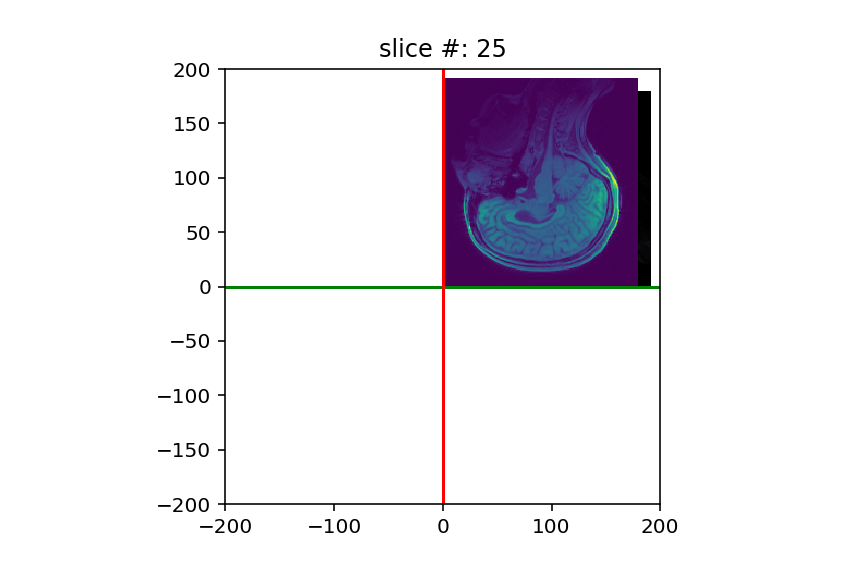

In [5]:
# load a slice near the middle of the volume, just for visualizaing
sliceNum = 25
slice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm = dicom.read_file(slice_fname[0])

plt.title('slice #: {}'.format(dcm.InstanceNumber))
plt.imshow(dcm.pixel_array, cmap='bone')
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='green')

In [6]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
pix_rot = np.rot90(dcm.pixel_array)

In [10]:
plt.imshow(pix_rot, cmap='bone')
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.axhline(y=0, color='green')
plt.axvline(x=0, color='red')


### start building the affine

In [11]:
# start with an identity matrix. Subsequent steps will overwrite values in the matrix
affine = np.eye(4)
affine

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [12]:
np.set_printoptions(precision=3, suppress=True)

# extract the reformat the ImageOrientationPatient Info
iop = dcm.ImageOrientationPatient
print('ImageOrientationPatient:')
print(iop, end='\n\n')

# reshape the image orientation patient
iop = np.array(iop).reshape(3,2, order='F')
print('orig -----')
print(iop, end='\n\n')


ImageOrientationPatient:
['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']

orig -----
[[ 0.056  0.04 ]
 [ 0.998 -0.002]
 [ 0.    -0.999]]



This is pretty close to an affine matrix that looks like:

In [13]:
np.matrix([[0,0],
         [1,0],
         [0,-1]])


matrix([[ 0,  0],
        [ 1,  0],
        [ 0, -1]])

This means that the x axis goes from (1,0,0) to (0,1,0) -- i.e. gets rotated into the y-axis

and the y axis goes from (0,1,0) to (0,0,-1) -- i.e. gets rotated into the negative z-axis

## back to basics: Try to build the DICOM AFFINE

In [16]:
sliceFiles = glob.glob('data/series0017/*.IMA')
print('total number of slices: {}'.format(len(sliceFiles)))

total number of slices: 52


In [17]:
# read in the first slice
firstSlice_fname = 'data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.0001.2017.10.24.12.31.58.663479.31905939.IMA'
dcm_first = dicom.read_file(firstSlice_fname)

# read in the last slice
sliceNum = 52
lastSlice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm_last = dicom.read_file(lastSlice_fname[0])

In [22]:
# This will build an affine matrix that will take the data to RAS+. Affine is built using values in the DICOM tags
# that are set to take the image to LPS+, but here we just invert the first 2 rows to get it to RAS+

# Get image orientation values
image_orient1 = np.array(dcm_first.ImageOrientationPatient)[0:3]
image_orient2 = np.array(dcm_first.ImageOrientationPatient)[3:6]

# pixel spacing
delta_r = float(dcm_first.PixelSpacing[0])
delta_c = float(dcm_first.PixelSpacing[1])

# image position
first_img_pos = np.array(dcm_first.ImagePositionPatient)
last_img_pos = np.array(dcm_last.ImagePositionPatient)
step = (first_img_pos - last_img_pos) / (1-len(sliceFiles))

affine = np.matrix([
    [-image_orient1[0] * delta_r,  -image_orient2[0] * delta_c, -step[0],  -first_img_pos[0]],
    [-image_orient1[1] * delta_r,  -image_orient2[1] * delta_c, -step[1],  -first_img_pos[1]],
    [image_orient1[2] * delta_r,   image_orient2[2] * delta_c,  step[2],  first_img_pos[2]],
    [0, 0, 0, 1]
    ])

affine

matrix([[  -0.074,   -0.053,   -2.993,   88.151],
        [  -1.331,    0.003,    0.167,  134.388],
        [   0.   ,   -1.332,    0.12 ,   59.742],
        [   0.   ,    0.   ,    0.   ,    1.   ]])

In [19]:
nib.aff2axcodes(affine)

('P', 'I', 'L')

## Test the affine out by building full data matrix and saving nifti to disk

In [29]:
sliceFiles = glob.glob('data/series0017/*.IMA')
print(len(sliceFiles))

# loop over all images, extract pixel_array, add to 3D array
for i,sl in enumerate(sliceFiles):
    
    # load the file
    dcm = dicom.read_file(join('.', sl))
    
    # get the pixel info
    pixel_array = dcm.pixel_array.T
    
    if i == 0:
        # preallocate an empty matrix to store all slices
        imageMatrix = np.zeros(shape=(pixel_array.shape[0], 
                                       pixel_array.shape[1], 
                                       len(sliceFiles))
                               )
    
    # get slice index
    slIdx = int(dcm.InstanceNumber) - 1
    
    # add slice to matrix
    imageMatrix[:,:,slIdx] = pixel_array

imageMatrix.shape

52


(180, 192, 52)

In [30]:
testImg = nib.Nifti1Image(imageMatrix, affine)
nib.save(testImg, 'testImg.nii.gz')

In [33]:
canonical_testImg = nib.as_closest_canonical(testImg)

In [34]:
testImg.affine

array([[  -0.074,   -0.053,   -2.993,   88.151],
       [  -1.331,    0.003,    0.167,  134.388],
       [   0.   ,   -1.332,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [35]:
canonical_testImg.affine

array([[   2.993,    0.074,    0.053,  -88.015],
       [  -0.167,    1.331,   -0.003,  -94.802],
       [  -0.12 ,   -0.   ,    1.332, -188.579],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [36]:
nib.aff2axcodes(canonical_testImg.affine)

('R', 'A', 'S')

In [38]:
canonical_testImg.shape

(52, 180, 192)

In [43]:
nib.__file__

'/usr/local/lib/python3.6/site-packages/nibabel/__init__.py'

<IPython.core.display.Javascript object>


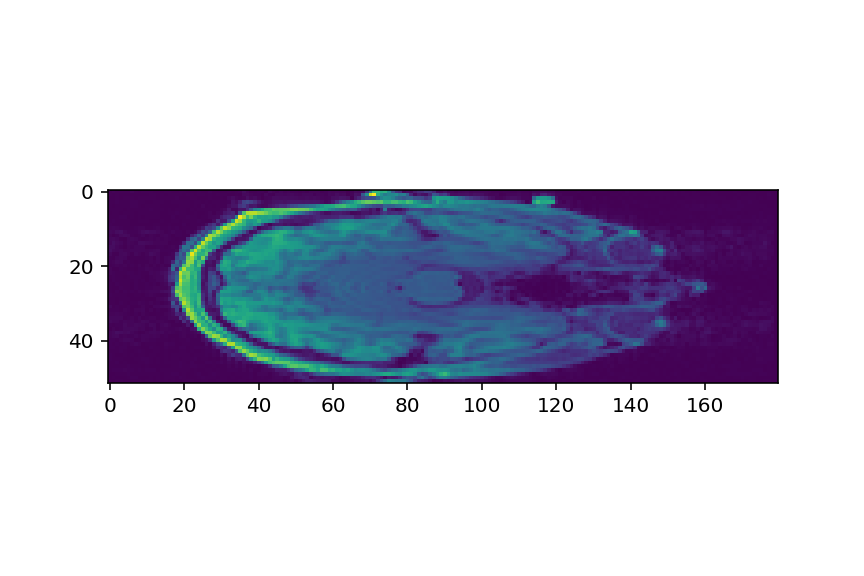

In [42]:
plt.imshow(canonical_testImg.get_data()[:,:,100])

In [37]:
nib.save(canonical_testImg, 'test2.nii.gz')

In [31]:
# reorder the axes 
affineTest = affine[:,[2,0,1,3]]
nib.aff2axcodes(affineTest)

('L', 'P', 'I')

In [32]:
t = np.eye(4)
nib.aff2axcodes(t)

('R', 'A', 'S')